In [1]:
import os
from pathlib import Path


titles, articles, labels = [], [], []
news_list = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']
for i, media in enumerate(news_list):
    files = os.listdir(Path('text', media))
    for file_name in files:
        if file_name == 'LICENSE.txt':
            continue
        with Path('text', media, file_name).open(encoding='utf-8') as f:
            lines = [line for line in f]
            title = lines[2].replace('\n', '')
            text = ''.join(lines[3:])
            titles.append(title)
            articles.append(text.replace('\n', ''))
            labels.append(i)

In [2]:
import pandas as pd
df = pd.DataFrame({'title': titles, 'article': articles, 'label': labels})
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df[['article', 'title']], df['label'], stratify=df['label'], test_size=0.15, random_state=0)
train_X, val_X, train_y, val_y = train_test_split(train_X[['article', 'title']], train_y, stratify=train_y, test_size=0.177, random_state=0)

In [4]:
train_df = train_X
train_df['label'] = train_y

val_df = val_X
val_df['label'] = val_y

test_df = test_X
test_df['label'] = test_y

In [5]:
from chariot.transformer.text.base import TextFilter
import re


class RegularExpressionReplacer(TextFilter):

    def __init__(self, pattern, replacement, copy=True):
        super().__init__(copy)
        self.pattern = pattern
        self.replacement = replacement

    def apply(self, text):
        return re.sub(self.pattern, self.replacement, text)

In [43]:
from chariot.dataset_preprocessor import DatasetPreprocessor
from chariot.transformer.formatter import Padding
import chariot.transformer as ct


pad_length = 300

dp = DatasetPreprocessor()
dp.process('article')\
    .by(ct.text.UnicodeNormalizer())\
    .by(ct.text.LowerNormalizer())\
    .by(RegularExpressionReplacer(pattern=' |　', replacement=''))\
    .by(RegularExpressionReplacer(pattern='■.+?\n', replacement=''))\
    .by(ct.text.SymbolFilter())\
    .by(ct.Tokenizer('ja'))\
    .by(ct.token.StopwordFilter('ja'))\
    .by(ct.Vocabulary(min_df=3, max_df=200.0))\
    .by(Padding(length=pad_length))\
    .fit(train_df['article'])

In [44]:
dp.process('label')\
    .by(ct.formatter.CategoricalLabel(num_class=9))

In [45]:
import time


start = time.time()
preprocessed = dp(train_df).preprocess().format().processed
end = time.time()
print(end-start)

601.7390420436859


In [46]:
val_preprocessed = dp(val_df).preprocess().format().processed

In [13]:
from chariot.storage import Storage
import os
import sys
from pathlib import Path


def set_path():
    if "../" not in sys.path:
        sys.path.append("../")
    root_dir = Path.cwd()
    return root_dir

ROOT_DIR = set_path()

storage = Storage.setup_data_dir(ROOT_DIR)

In [ ]:
_ = storage.chakin(name='fastText(ja)')

In [47]:
embedding = dp.process('article').preprocessor.vocabulary.make_embedding(storage.data_path('external/fasttext(ja).vec'))

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class  CNN_Text(nn.Module):
    
    def __init__(self, pretrained_wv, output_dim, kernel_num, kernel_sizes=[3,4,5], dropout=0.5, static=False):
        super(CNN_Text,self).__init__()
        
        weight = torch.from_numpy(pretrained_wv)
        self.embed = nn.Embedding.from_pretrained(weight, freeze=False)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, kernel_num, (k, self.embed.weight.shape[1])) for k in kernel_sizes])
        self.bns1 = nn.ModuleList([nn.BatchNorm2d(kernel_num) for _ in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(kernel_sizes)*kernel_num, output_dim)
        self.static = static

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3) #(N,Co,W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x


    def forward(self, x):
        x = self.embed(x) # (N,W,D)
        
        if self.static:
            x = x.detach()

        x = x.unsqueeze(1) # (N,Ci,W,D)
        x = x.float()
        x = [F.relu(bn(conv(x))).squeeze(3) for conv, bn in zip(self.convs1, self.bns1)] #[(N,Co,W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] #[(N,Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x) # (N,len(Ks)*Co)
        logit = self.fc1(x) # (N,C)
        return logit

In [54]:
from sklearn.metrics import accuracy_score

def calc_accuray(model, target_preprocessed, writer, ite, mode, use_cuda):
    model.eval()
    feature = torch.LongTensor(target_preprocessed['article'])
    if use_cuda:
        feature = feature.cuda()
    forward = model(feature)
    predicted_label = forward.argmax(dim=1).cpu()
    test_target = torch.LongTensor(np.argmax(target_preprocessed['label'], axis=1))
    accuracy = accuracy_score(test_target.numpy(), predicted_label.numpy())
    writer.add_scalar('data/{}_accuracy'.format(mode), accuracy, ite)
    model.train()
    return accuracy

In [60]:
output_dim = 9
kernel_num = 200
kernel_sizes = [3,4,5,7]
dropout = 0.5

In [61]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

In [62]:
model = CNN_Text(embedding, output_dim, kernel_num, kernel_sizes, dropout)

In [63]:
import torch
import numpy as np
import adabound

model = CNN_Text(embedding, output_dim, kernel_num, kernel_sizes, dropout)
use_cuda = True
opt = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1, weight_decay=5e-4)
# opt = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
model.train()
if use_cuda:
    model = model.cuda()
    
loss_list = []
for ite, b in enumerate(dp.iterate(preprocessed, batch_size=64, epoch=400)):
    feature = torch.LongTensor(b['article'])
    target = torch.LongTensor(np.argmax(b['label'], axis=1))
    if use_cuda:
        feature = feature.cuda()
        target = target.cuda()
        
    opt.zero_grad()
    logit = model(feature)
    loss = F.nll_loss(F.log_softmax(logit), target)
    loss.backward()
    opt.step()
    # scheduler.step()
    writer.add_scalar('data/training_loss', loss.item(), ite)
    # print(loss.item())
    loss_list.append(loss.item())
    
    # check training accuray
    calc_accuray(model, b, writer, ite, 'training', use_cuda)
    
    # check validation accuracy
    if ite % 100 == 0:
        # calc training accuracy
        calc_accuray(model, val_preprocessed, writer, ite, 'validation', use_cuda)

writer.close()

c:\users\user\anaconda3\envs\chariot-pytorch\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [64]:
lr = 0.01

for i in range(10):
    writer = SummaryWriter()
    use_cuda = True
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    # opt = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1, weight_decay=5e-4)
    # opt = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
    model.train()
    if use_cuda:
        model = model.cuda()

    loss_list = []
    for ite, b in enumerate(dp.iterate(preprocessed, batch_size=64, epoch=10)):
        feature = torch.LongTensor(b['article'])
        target = torch.LongTensor(np.argmax(b['label'], axis=1))
        if use_cuda:
            feature = feature.cuda()
            target = target.cuda()

        opt.zero_grad()
        logit = model(feature)
        loss = F.nll_loss(F.log_softmax(logit), target)
        loss.backward()
        opt.step()
        # scheduler.step()
        writer.add_scalar('data/training_loss', loss.item(), ite)
        # print(loss.item())
        loss_list.append(loss.item())

        # check training accuray
        calc_accuray(model, b, writer, ite, 'training', use_cuda)

        # check validation accuracy
        if ite % 100 == 0:
            # calc training accuracy
            calc_accuray(model, val_preprocessed, writer, ite, 'validation', use_cuda)

    writer.close()
    lr = lr / 5

c:\users\user\anaconda3\envs\chariot-pytorch\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Optunaでのチューニング

In [58]:
from tensorboardX import SummaryWriter

def objective(trial):
    kernel_num = trial.suggest_int('kernel_num', 80, 200)
    dropout = trial.suggest_uniform('dropout', 0.0, 1.0)
    kernel_sizes = [3, 4, 5, 7]
    output_dim = 9
    model = CNN_Text(embedding, output_dim, kernel_num, kernel_sizes, dropout)
    use_cuda = True
    opt = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1, weight_decay=5e-4)
    
    writer = SummaryWriter()
    model.train()
    if use_cuda:
        model = model.cuda()

    for ite, b in enumerate(dp.iterate(preprocessed, batch_size=64, epoch=200)):
        feature = torch.LongTensor(b['article'])
        target = torch.LongTensor(np.argmax(b['label'], axis=1))
        if use_cuda:
            feature = feature.cuda()
            target = target.cuda()

        opt.zero_grad()
        logit = model(feature)
        loss = F.nll_loss(F.log_softmax(logit), target)
        loss.backward()
        opt.step()
        # scheduler.step()
        writer.add_scalar('data/training_loss', loss.item(), ite)

        # check training accuray
        calc_accuray(model, b, writer, ite, 'training', use_cuda)

        # check validation accuracy
        if ite % 100 == 0:
            # calc training accuracy
            calc_accuray(model, val_preprocessed, writer, ite, 'validation', use_cuda)

    writer.close()
    accuracy = calc_accuray(model, val_preprocessed, writer, ite, 'validation', use_cuda)
    return 1.0-accuracy

In [ ]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=70)

In [65]:
test_preprocessed = dp(test_df).preprocess().format().processed

In [66]:
model.eval()
feature = torch.LongTensor(test_preprocessed['article']).cuda()
forward = model(feature)

In [127]:
predicted_label = forward.argmax(dim=1).cpu()
test_target_labels = torch.LongTensor(np.argmax(test_preprocessed['label'], axis=1))

In [128]:
from sklearn.metrics import classification_report

print(classification_report(test_target_labels.numpy(), predicted_label.numpy()))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       131
           1       0.75      0.91      0.82       131
           2       0.81      0.74      0.77       130
           3       0.74      0.62      0.68        77
           4       0.94      0.91      0.92       130
           5       0.75      0.90      0.82       126
           6       0.99      0.84      0.91       131
           7       0.93      0.93      0.93       135
           8       0.84      0.88      0.86       115

   micro avg       0.85      0.85      0.85      1106
   macro avg       0.85      0.84      0.84      1106
weighted avg       0.86      0.85      0.85      1106



In [130]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_target_labels.numpy(), predicted_label.numpy()))

0.849005424954792


In [132]:
correct_data, diff_data = [], []
for i, (p, t) in enumerate(zip(predicted_label.numpy(), test_target_labels.numpy())):
    if p == t:
        correct_data.append(i)
    else:
        diff_data.append(i)

# GradCamによるモデルの可視化

In [70]:
# こちらのコードをお借りした
# https://tech.jxpress.net/entry/2018/12/12/130057
class GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self, output, target):
        self.model.zero_grad()
        one_hot_output = torch.zeros([1, output.size()[-1]]).cuda()
        one_hot_output[0][target] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()

# 予測が正しい場合のモデルの解釈

In [215]:
news_id = 20
grad_cam = GradCAM(model=model, feature_layer=model.convs1[3])
test_input = test_preprocessed['article'][news_id:news_id+1]
test_tensor = torch.LongTensor(test_input).cuda()
test_target = torch.LongTensor(np.argmax(test_preprocessed['label'][news_id:news_id+1], axis=1))
model_output = grad_cam.forward(test_tensor)
predicted_label = model_output.argmax().item()
print('Predict label: {}'.format(predicted_label))
print('True label: {}'.format(test_target.item()))

Predict label: 4
True label: 4


In [216]:
grad_cam.backward_on_target(model_output, predicted_label)

In [217]:
import numpy as np
feature_grad = grad_cam.feature_grad.cpu().data.numpy()[0]
weights = np.mean(feature_grad, axis=(1, 2))
feature_map = grad_cam.feature_map.cpu().data.numpy()
grad_cam.clear_hook()

In [218]:
cam = np.sum((weights * feature_map.T), axis=2).T
cam = np.maximum(cam, 0)

In [219]:
cam7 = cam

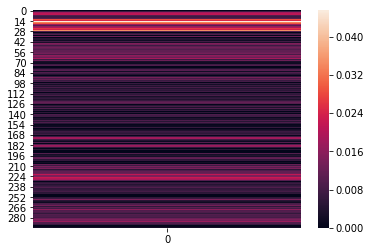

In [220]:
import seaborn as sns
%matplotlib inline
sns.heatmap(cam)

In [143]:
inv = dp.process('article').preprocessor.vocabulary.inverse(test_preprocessed['article'][news_id])

In [144]:
trigrams = [''.join(inv[i:i+3]) for i in range(len(inv))]

In [145]:
trigrams

['@@UNKNOWN@@の衝撃',
 'の衝撃を',
 '衝撃を呼ぶ',
 'を呼ぶ3',
 '呼ぶ3d',
 '3dエピック',
 'dエピック・',
 'エピック・ミステリー',
 '・ミステリー巨編',
 'ミステリー巨編が',
 '巨編が日本',
 'が日本上陸',
 '日本上陸@@UNKNOWN@@',
 '上陸@@UNKNOWN@@『',
 '@@UNKNOWN@@『エイリアン',
 '『エイリアン』',
 'エイリアン』『',
 '』『グラディエーター',
 '『グラディエーター』',
 'グラディエーター』の',
 '』の巨匠',
 'の巨匠リドリー・スコット',
 '巨匠リドリー・スコット監督',
 'リドリー・スコット監督の',
 '監督の最新',
 'の最新『',
 '最新『プロメテウス',
 '『プロメテウス』',
 'プロメテウス』@@UNKNOWN@@',
 '』@@UNKNOWN@@8',
 '@@UNKNOWN@@824',
 '824公開',
 '24公開@@UNKNOWN@@',
 '公開@@UNKNOWN@@が',
 '@@UNKNOWN@@が謎',
 'が謎だらけ',
 '謎だらけの',
 'だらけのキャンペーン',
 'のキャンペーンを',
 'キャンペーンを開始',
 'を開始する',
 '開始する。',
 'する。さらに',
 '。さらに、',
 'さらに、日本',
 '、日本版',
 '日本版ポスター',
 '版ポスター2',
 'ポスター2弾',
 '2弾が',
 '弾が公開',
 'が公開さ',
 '公開され',
 'された',
 'れた。',
 'た。本',
 '。本は',
 '本は、',
 'は、人類',
 '、人類史上',
 '人類史上最大',
 '史上最大の',
 '最大の謎',
 'の謎“',
 '謎“人類',
 '“人類の',
 '人類の起源',
 'の起源”',
 '起源”を',
 '”を解き明かす',
 'を解き明かす重大',
 '解き明かす重大な',
 '重大なヒント',
 'なヒントを',
 'ヒントを地球',
 'を地球の',
 '地球の古代',
 'の古代遺跡',
 '古代遺跡で',
 '遺跡で発見',
 'で発見し',
 '発見し、',
 'し、宇宙船',
 '、宇宙船プロメテウス',


In [146]:
inv = dp.process('article').preprocessor.vocabulary.inverse(test_preprocessed['article'][news_id])
trigrams = [''.join(inv[i:i+3]) for i in range(len(inv))]

l = np.array([e[0]for e in cam])

K = 20
raw_topk_indices = np.argpartition(-l, K)[:K]
topk_values = l[raw_topk_indices]
indices = np.argsort(-topk_values)

topk_indices = raw_topk_indices[indices]

In [147]:
for idx in topk_indices:
    print(trigrams[idx])

『プロメテウス』
『グラディエーター』
『エイリアン』
824公開
弾が公開
また、劇場
』『グラディエーター
3d作品
エイリアン』『
』の巨匠
d作品の
。当日上映
を順次上映
の最新『
最新『プロメテウス
映像が上映
映像が上映
・ミステリー巨編
dエピック・
作品の最終


In [347]:
model_output

tensor([[  5.9591, -15.4322, -12.2182,   2.7349,   3.5685,   5.1419, -19.0625,
          -1.7443,   0.2661]], device='cuda:0', grad_fn=<AddmmBackward>)

# 3, 4, 5, 7-gramのスコアを使った判断根拠のヒートマップ

In [234]:
gradients = np.zeros(len(inv))

In [235]:
for i, v in enumerate(cam3):
    gradients[i: i+3] += v
    
for i, v in enumerate(cam4):
    gradients[i: i+4] += v
    
for i, v in enumerate(cam5):
    gradients[i: i+5] += v
    
for i, v in enumerate(cam7):
    gradients[i: i+7] += v
    
gradients = gradients / 4.0

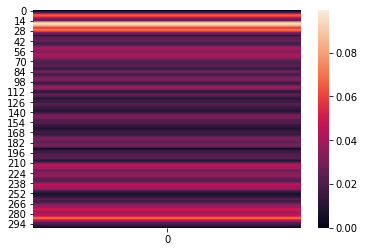

In [240]:
sns.heatmap(gradients.reshape(300, 1))

# 予測が失敗した場合のモデルの解釈

In [148]:
diff_data

[8,
 10,
 15,
 16,
 27,
 33,
 48,
 54,
 58,
 64,
 69,
 79,
 81,
 83,
 86,
 105,
 107,
 109,
 117,
 119,
 127,
 128,
 132,
 160,
 161,
 170,
 174,
 182,
 183,
 186,
 188,
 192,
 203,
 229,
 230,
 236,
 245,
 247,
 248,
 253,
 267,
 280,
 281,
 302,
 322,
 326,
 332,
 335,
 337,
 342,
 344,
 355,
 385,
 389,
 392,
 396,
 402,
 415,
 426,
 429,
 434,
 438,
 451,
 455,
 456,
 457,
 459,
 472,
 476,
 482,
 484,
 487,
 501,
 502,
 510,
 525,
 528,
 532,
 533,
 544,
 556,
 557,
 563,
 573,
 574,
 588,
 591,
 592,
 595,
 602,
 605,
 606,
 621,
 623,
 632,
 634,
 638,
 642,
 645,
 646,
 652,
 674,
 678,
 679,
 693,
 695,
 700,
 708,
 710,
 712,
 713,
 714,
 723,
 725,
 743,
 753,
 754,
 759,
 764,
 774,
 784,
 785,
 788,
 809,
 830,
 832,
 833,
 834,
 839,
 840,
 842,
 846,
 853,
 863,
 872,
 873,
 878,
 883,
 891,
 896,
 901,
 911,
 916,
 923,
 927,
 934,
 940,
 963,
 965,
 968,
 972,
 978,
 987,
 991,
 993,
 1000,
 1011,
 1031,
 1032,
 1045,
 1046,
 1059,
 1071,
 1074,
 1075,
 1079,
 1080]

In [178]:
# 予測が失敗した場合のモデルの解釈
news_id = 58
grad_cam = GradCAM(model=model, feature_layer=model.convs1[0])
test_input = test_preprocessed['article'][news_id:news_id+1]
test_tensor = torch.LongTensor(test_input).cuda()
test_target = torch.LongTensor(np.argmax(test_preprocessed['label'][news_id:news_id+1], axis=1))
model_output = grad_cam.forward(test_tensor)
predicted_label = model_output.argmax().item()
print('Predict label: {}'.format(predicted_label))
print('True label: {}'.format(test_target.item()))

Predict label: 5
True label: 0


In [179]:
grad_cam.backward_on_target(model_output, predicted_label)

In [180]:
import numpy as np
feature_grad = grad_cam.feature_grad.cpu().data.numpy()[0]
weights = np.mean(feature_grad, axis=(1, 2))
feature_map = grad_cam.feature_map.cpu().data.numpy()
grad_cam.clear_hook()

In [181]:
cam = np.sum((weights * feature_map.T), axis=2).T
cam = np.maximum(cam, 0)

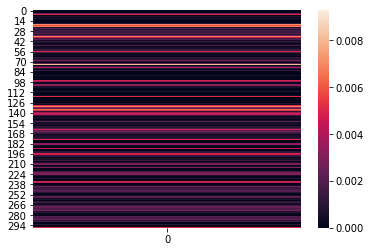

In [182]:
import seaborn as sns
sns.heatmap(cam)

In [184]:
inv = dp.process('article').preprocessor.vocabulary.inverse(test_preprocessed['article'][news_id])
trigrams = [''.join(inv[i:i+3]) for i in range(len(inv))]

l = np.array([e[0]for e in cam])

K = 20
raw_topk_indices = np.argpartition(-l, K)[:K]
topk_values = l[raw_topk_indices]
indices = np.argsort(-topk_values)

topk_indices = raw_topk_indices[indices]

In [185]:
for idx in topk_indices:
    print(trigrams[idx])

「独通信
は独、
未婚女性のみ
未婚女性の
シングル女性の
独身女性が
の恋や
の恋や
と恋に
女性の恋
独、負け犬
恋に落ちる
の独身女性
恋、日常
独通信の
「おひとり
「おひとり
「おひとり
「おひとり
「おひとり


In [190]:
josei_labels = train_df[train_df['article'].str.contains('女性')]['label']

In [195]:
from collections import Counter

cnt = Counter(josei_labels)
for t in cnt.most_common():
    print(t)

(0, 423)
(5, 287)
(4, 162)
(8, 102)
(3, 66)
(7, 51)
(2, 50)
(6, 16)
(1, 13)
